# Sparkify Churn Prediction
In this project, the problem statement is to predict the churning of users whom use streaming service of a fictional company called “Sparkify”. At Sparkify, there is a dataset totaling 12GB of event logs where a small subset of 128MB was taken to allow us work on exploring the dataset and building a model that can later be deployed on the cloud (such as AWS EMR). Identifying and analyzing churn is a common and important task for data scientist to be aware of. For a company like Sparkify to predict potentially churning users can allow them to take the effort to retain those users and therefore saving revenue which would otherwise be very difficult to generate.

In [60]:
# importing libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col

import pandas as pd
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier


import seaborn as sns

from pyspark.ml.classification import (NaiveBayes, LogisticRegression, DecisionTreeClassifier, 
                                       RandomForestClassifier, LinearSVC)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time

In [2]:
# creating a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn") \
    .getOrCreate()

# Loading and Cleaning Dataset
In this section, I will load and clean the data set `mini_sparkify_event_data.json`, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
user_log = spark.read.json("./mini_sparkify_event_data.json")

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
user_log.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_log.columns]).toPandas()


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [6]:
#removing rows where userId == "" because these are guest website visitors and not active users that can churn, so we exclude them from this analysis
user_log = user_log.filter(user_log.userId != "")


# Exploratory Data Analysis
performing EDA by loading a small subset of the data and doing basic manipulations within Spark. 



In [7]:
user_log.select('auth').toPandas().auth.value_counts()

Logged In    278102
Cancelled        52
Name: auth, dtype: int64

it seems that cancelled rows means that these are churned users

In [8]:
user_log.select('page').toPandas().page.value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Name: page, dtype: int64

In [9]:
#compiling ids of cancelled users
cancelled_user_ids = user_log.where(col('auth')=='Cancelled').toPandas().userId

In [10]:
cancelled_user_ids

0         18
1         32
2        125
3        105
4         17
5        143
6        101
7        129
8        121
9         51
10        87
11       122
12        12
13        58
14        73
15         3
16       106
17       103
18        28
19        54
20        29
21        70
22        53
23    100011
24    100001
25    100024
26    100006
27    100019
28    100003
29    100023
30    100005
31    100017
32    100025
33    100009
34    100012
35    100013
36    100022
37    100014
38    100015
39    100021
40    100007
41    200001
42    200024
43    200011
44    200021
45    200018
46    200015
47    200017
48    200016
49    200020
50    300007
51    300001
Name: userId, dtype: object

### Defining Churn

Here we define churn as the user confirming cancellation of service from the occurance of `Cancellation Confirmation` page of the user id. 


In [11]:
#adding a new column called 'churn', apply 1 to it if the user has churned and 0 to it if he hasn't, this way we can follow their activities through the events
user_log = user_log.withColumn(
    'Churn',
    when(col('userId').isin(list(cancelled_user_ids)), 1) \
    .otherwise(0)
)

### Explore Data
After defining churn, I am performing some exploratory data analysis to observe the behavior for users who stayed vs users who churned. I will explore aggregates on these two groups of users, observing how much of a specific action they experienced.

In [12]:
#checking percentage of total event activities by churned users compared to all events by all users
user_log.where(col('Churn') == 1).count() / user_log.count()

0.16129194618808287

In [13]:
#number of churned users compared to the total number of users
len(cancelled_user_ids) / user_log.dropDuplicates(['userId']).count()

0.2311111111111111

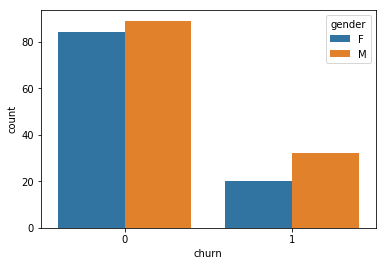

In [14]:
#gender and churn
gender_churn_df = user_log.dropDuplicates(['userId']).groupby(['churn','gender']).count().toPandas()
sns.barplot(x="churn", y="count", data=gender_churn_df, hue="gender")


**from percentage of churning, seems like males are more likely to churn**

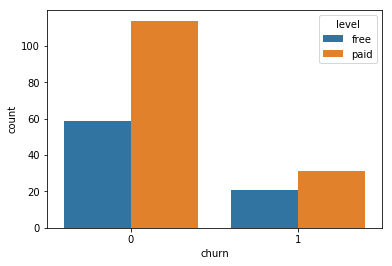

In [15]:
level_churn_df = user_log.orderBy(col("ts").desc()).dropDuplicates(['userId']).groupby(['churn','level']).count().toPandas()
sns.barplot(x="churn", y="count", data=level_churn_df, hue="level")


In [16]:
#lets check the percentage
level_churn_df 

,churn,level,count
0,0,free,59
1,0,paid,114
2,1,paid,31
3,1,free,21


**slightly higher percentage of free users churning...**

In [17]:
#count of sessions and churn
count_sessions = user_log.select("userId", "churn", "sessionId").dropDuplicates().groupby("userId").count().withColumn(
        'Churn',
        when(col('userId').isin(list(cancelled_user_ids)), 1) \
        .otherwise(0)
        ).toPandas()

count_sessions.head()

,userId,count,Churn
0,200002,6,0
1,100010,7,0
2,125,1,1
3,124,29,0
4,51,10,1


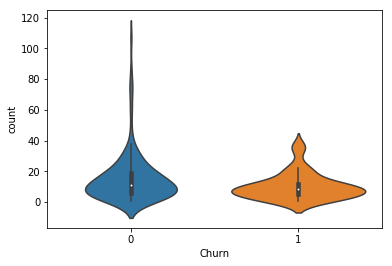

In [18]:
sns.violinplot(x="Churn", y="count", data=count_sessions)

interesting, can we say that anyone that has more session counts than 50 will not churn?

In [19]:
#last activities and churn

last_activity_activity_df = user_log.orderBy(col("ts").desc()).where(col('page')=='NextSong').dropDuplicates(['userId'])


In [20]:
last_activity_activity_df.show(5)

+-----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+---------------+------+-------------+--------------------+------+-----+
|     artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|           song|status|           ts|           userAgent|userId|Churn|
+-----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+---------------+------+-------------+--------------------+------+-----+
| Lily Allen|Logged In| Darianna|     F|           33|Carpenter|185.25995| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|      187|             22|   200|1542823951000|"Mozilla/5.0 (iPh...|100010|    0|
|Josh Turner|Logged In|  Dominic|     M|          142|   Torres|149.57669| paid|Chicago-Napervill...|   PUT|NextSong|1536269906000|      205|  One W

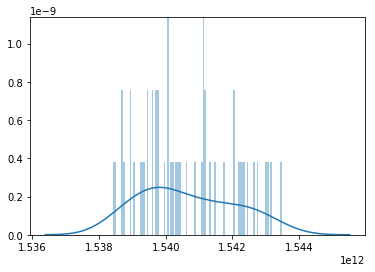

In [21]:
sns.distplot(last_activity_activity_df.where(col('Churn') == 1).select('ts').toPandas(), bins=100)

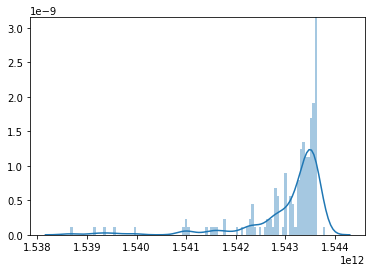

In [22]:
sns.distplot(last_activity_activity_df.where(col('Churn') == 0).select('ts').toPandas(), bins=100)

non churning users tend to have a recent latest activity, we'll include it in our feature engineering to feed into the model

In [23]:
# total time listened and churn

total_length = user_log.select("userId", "length","Churn").groupby("userId","Churn").sum()

total_length.show(5)

+------+-----+------------------+----------+
|userId|Churn|       sum(length)|sum(Churn)|
+------+-----+------------------+----------+
|    19|    0|54480.933869999986|         0|
|100005|    1| 37037.12201000001|       216|
|200007|    0|15739.869310000002|         0|
|300007|    1| 28028.71048000002|       143|
|    50|    0|122751.27560999991|         0|
+------+-----+------------------+----------+
only showing top 5 rows



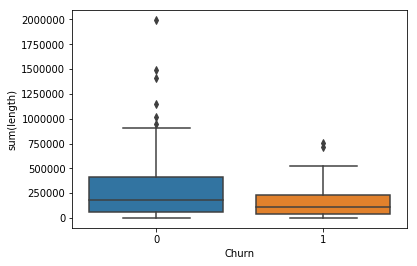

In [24]:
sns.boxplot(data = total_length.toPandas(), x="Churn", y="sum(length)")

ok it seems clear that on average, churned users have a less total listening time that not churned users

In [25]:
# number of thumbs up and churn

thumbs_up =  user_log.where(col('page')=='Thumbs Up').groupby('userId','Churn').count()

thumbs_up.show(5)

+------+-----+-----+
|userId|Churn|count|
+------+-----+-----+
|    19|    0|    5|
|100005|    1|    7|
|200007|    0|    2|
|300007|    1|   11|
|    50|    0|   27|
+------+-----+-----+
only showing top 5 rows



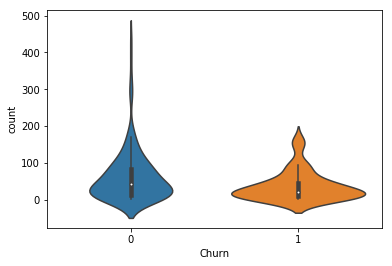

In [26]:
sns.violinplot(data = thumbs_up.toPandas(), x="Churn", y="count")

it is clear that non churning users have more thumbsup on average, let's see if churning users tend to have more thumbs down on average

In [27]:
# number of thumbs down and churn

thumbs_down =  user_log.where(col('page')=='Thumbs Down').groupby('userId','Churn').count()

thumbs_down.show(5)

+------+-----+-----+
|userId|Churn|count|
+------+-----+-----+
|    19|    0|    2|
|100005|    1|    3|
|300007|    1|    1|
|    50|    0|    3|
|200002|    0|    6|
+------+-----+-----+
only showing top 5 rows



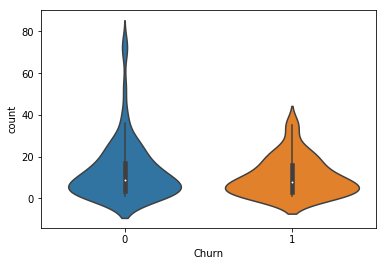

In [28]:
sns.violinplot(data = thumbs_down.toPandas(), x="Churn", y="count")

Wow, what a chart!!! it seems that the distribution between churning and non churning users with Thumbs Down is similar except for the anomalies of high thumbs down counts of non churning users. I think those are just over hitting thumbs ups and downs. Let's see if the same users have high numbers of thumbs ups and downs.

In [29]:
#for fun, checking if same users tend to hit high numbers of thumbs ups and downs. 


In [30]:
thumbs_up.where(col('count') > 190).toPandas()

,userId,Churn,count
0,300011,0,437
1,300017,0,303
2,300021,0,336
3,39,0,388
4,140,0,277
5,92,0,292
6,300015,0,193
7,85,0,192


In [31]:
thumbs_down.where(col('count') > 39).toPandas()

,userId,Churn,count
0,200008,0,52
1,200023,0,73
2,300011,0,41
3,39,0,69
4,140,0,75
5,200004,0,54
6,124,0,41
7,92,0,72


In [32]:
int_df = pd.merge(thumbs_up.where(col('count') > 190).toPandas(), thumbs_down.where(col('count') > 39).toPandas(), how ='inner', on ='userId')


In [33]:
print(int_df)

   userId  Churn_x  count_x  Churn_y  count_y
0  300011        0      437        0       41
1      39        0      388        0       69
2     140        0      277        0       75
3      92        0      292        0       72


I think we can conclude that anomally high activity of thumbs up or down tend to insinuate nonchurning user

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [34]:
#we will include gender to our feature set for training the model

encoded_gender = user_log.select("userId", "gender").dropDuplicates().replace(["M", "F"], ["0", "1"], "gender").select("userId", col("gender").cast("int"))

encoded_gender.show(3)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
+------+------+
only showing top 3 rows



In [95]:
#including user's last level

encoded_level = user_log.orderBy(col("ts").desc()).select("userId", "level").dropDuplicates(['userId']).replace(["free", "paid"],['0', '1'], 'level').select("userId", col("level").cast("int"))

encoded_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows



In [36]:
#including num session counts
count_sessions = user_log.select('userId', 'sessionId').dropDuplicates().groupby("userId").count().withColumnRenamed('count', "sessions_count") 

count_sessions.show(5)

+------+--------------+
|userId|sessions_count|
+------+--------------+
|100010|             7|
|200002|             6|
|   125|             1|
|    51|            10|
|   124|            29|
+------+--------------+
only showing top 5 rows



In [37]:
#including latest activity
last_activity_activity_df = user_log.orderBy(col("ts").desc()).where(col('page')=='NextSong').dropDuplicates(['userId']).select('userId','ts')
last_activity_activity_df.show(5)

+------+-------------+
|userId|           ts|
+------+-------------+
|100010|1542823951000|
|200002|1542324353000|
|   125|1539318906000|
|   124|1543520717000|
|     7|1542955610000|
+------+-------------+
only showing top 5 rows



In [38]:
#including total time listened
total_length = user_log.select('userId', 'length').groupby('userId').sum().withColumnRenamed("sum(length)", 'total_listening_time') 

total_length.show(5)

+------+--------------------+
|userId|total_listening_time|
+------+--------------------+
|100010|   66940.89735000003|
|200002|   94008.87593999993|
|   125|  2089.1131000000005|
|    51|   523275.8428000004|
|   124|  1012312.0927899999|
+------+--------------------+
only showing top 5 rows



In [39]:
#including churn to be placed in the transformed event for training
churn = user_log.select('userId', col('churn')).dropDuplicates()

churn.show(3)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
+------+-----+
only showing top 3 rows



In [40]:
#including thumbs up and thumbs down
thumbs_up_df =  user_log.where(col('page')=='Thumbs Up').groupby('userId').count().withColumnRenamed("count", 'total_thumb_ups') 
thumbs_up_df.show(5)

thumbs_down_df =  user_log.where(col('page')=='Thumbs Down').groupby('userId').count().withColumnRenamed("count", 'total_thumb_downs') 
thumbs_down_df.show(5)

+------+---------------+
|userId|total_thumb_ups|
+------+---------------+
|100010|             17|
|200002|             21|
|    51|            100|
|   124|            171|
|     7|              7|
+------+---------------+
only showing top 5 rows

+------+-----------------+
|userId|total_thumb_downs|
+------+-----------------+
|100010|                5|
|200002|                6|
|    51|               21|
|   124|               41|
|     7|                1|
+------+-----------------+
only showing top 5 rows



In [90]:
thumbs_df = thumbs_up_df.join(thumbs_down_df,"userId","outer")
print(thumbs_df.count())
print(thumbs_df.dropDuplicates(['userId']).count())
thumbs_df.show(5)

221
221
+------+---------------+-----------------+
|userId|total_thumb_ups|total_thumb_downs|
+------+---------------+-----------------+
|100010|             17|                5|
|200002|             21|                6|
|   124|            171|               41|
|    51|            100|               21|
|     7|              7|                1|
+------+---------------+-----------------+
only showing top 5 rows



In [96]:
dataset_transformed = encoded_gender.join(encoded_level, "userId", "outer") \
    .join(count_sessions, "userId", "outer") \
    .join(last_activity_activity_df, "userId", "outer") \
    .join(total_length, "userId", "outer") \
    .join(churn, "userId", "outer") \
    .join(thumbs_df, "userId", "outer") \
    .drop('userId') \
    .fillna(0)

In [97]:
print(dataset_transformed.count())
dataset_transformed.show(5)

225
+------+-----+--------------+-------------+--------------------+-----+---------------+-----------------+
|gender|level|sessions_count|           ts|total_listening_time|churn|total_thumb_ups|total_thumb_downs|
+------+-----+--------------+-------------+--------------------+-----+---------------+-----------------+
|     1|    0|             7|1542823951000|   66940.89735000003|    0|             17|                5|
|     0|    0|             6|1542324353000|   94008.87593999993|    0|             21|                6|
|     0|    0|             1|1539318906000|  2089.1131000000005|    1|              0|                0|
|     1|    1|            29|1543520717000|  1012312.0927899999|    0|            171|               41|
|     0|    1|            10|1539761726000|   523275.8428000004|    1|            100|               21|
+------+-----+--------------+-------------+--------------------+-----+---------------+-----------------+
only showing top 5 rows



In [98]:
encoded_level.count()

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [99]:
#will first vectorize and scale numberic vars
numeric_vars = ['sessions_count','ts','total_listening_time',
                'total_thumb_ups','total_thumb_downs']
numeric_assembler = VectorAssembler(inputCols = numeric_vars,
                                    outputCol = "numericvectorized")
scaler = StandardScaler(inputCol = "numericvectorized", outputCol = "numericscaled",
                        withStd = True, withMean = True)
cat_binary_columns = ['gender','level']
total_assembler = VectorAssembler(inputCols = cat_binary_columns+["numericscaled"],
                                  outputCol ="ml_feats")

In [100]:
#building the pipeline that we will use on our dataset
data_pipeline = Pipeline(stages=[numeric_assembler, scaler, total_assembler])

#applying to the pipeline to our dataset
modeling_df = data_pipeline.fit(dataset_transformed).transform(dataset_transformed)

In [102]:
modeling_df.toPandas().head(5)

,gender,level,sessions_count,ts,total_listening_time,churn,total_thumb_ups,total_thumb_downs,numericvectorized,numericscaled,features
0,1,0,7,1542823951000,6.694090e+04,0,17,5,"[7.0, 1.542823951e+12, 66940.89735, 17.0, 5.0]","[-0.485806758374, 0.228805277708, -0.674000897...","[1.0, 0.0, -0.485806758374, 0.228805277708, -0..."
1,0,0,6,1542324353000,9.400888e+04,0,21,6,"[6.0, 1.542324353e+12, 94008.87594, 21.0, 6.0]","[-0.554080662581, -0.118740208464, -0.57571356...","[0.0, 0.0, -0.554080662581, -0.118740208464, -..."
2,0,0,1,1539318906000,2.089113e+03,1,0,0,"[1.0, 1.539318906e+12, 2089.1131, 0.0, 0.0]","[-0.895450183612, -2.20948024101, -0.909486122...","[0.0, 0.0, -0.895450183612, -2.20948024101, -0..."
3,1,1,29,1543520717000,1.012312e+06,0,171,41,"[29.0, 1.543520717e+12, 1012312.09279, 171.0, ...","[1.01621913416, 0.713510737335, 2.75876431726,...","[1.0, 1.0, 1.01621913416, 0.713510737335, 2.75..."
4,0,1,10,1539761726000,5.232758e+05,1,100,21,"[10.0, 1.539761726e+12, 523275.8428, 100.0, 21.0]","[-0.280985045756, -1.90143238616, 0.9830103746...","[0.0, 1.0, -0.280985045756, -1.90143238616, 0...."


In [103]:

# splitting data into train, validation and test sets
train, validation_test = modeling_df.randomSplit([0.7, 0.3], seed = 42)
validation, test = validation_test.randomSplit([0.5, 0.5], seed = 42)

In [109]:
# logistic regression
start = time()
lr = LogisticRegression(featuresCol='ml_feats', labelCol='churn')
lr_model = lr.fit(train)
end = time()

print('Total training time for logic regression: {} seconds'.format(end - start))

# random forest
start = time()
rf = RandomForestClassifier(featuresCol='ml_feats', labelCol='churn', seed=42)
rf_model = rf.fit(train)
end = time()

print('Total training time for Random Forest: {} seconds'.format(end - start))

# decision tree
start = time()
dt = DecisionTreeClassifier(featuresCol='ml_feats', labelCol='churn', seed=42)
dt_model = dt.fit(train)
end = time()

print('Total training time for Decision Tree: {} seconds'.format(end - start))


Total training time for logic regression: 80.31593489646912 seconds
Total training time for Random Forest: 116.7375123500824 seconds
Total training time for Decision Tree: 97.43992948532104 seconds


In [110]:
models = [lr_model,rf_model,dt_model]

model_names = ['logistic regression','random forest','decision tree']

# display results for ml models
for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    validation_prediction = model.transform(validation)
    evaluator1 = MulticlassClassificationEvaluator(labelCol='churn') # using evaluator
    evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churn')
    # make evaluation and print f1-score and area under PR per model
    print('F1 score: {}'.format((model_name), (evaluator1.evaluate(
        validation_prediction, {evaluator1.metricName:'f1'}))))
    
    print('')

F1 score for logistic regression on validation set: 0.6476190476190476
Area under PR for logistic regression on validation set: 0.8809523809523809

F1 score for random forest on validation set: 0.7447552447552448
Area under PR for random forest on validation set: 0.9107142857142858

F1 score for decision tree on validation set: 0.5745920745920746
Area under PR for decision tree on validation set: 0.7023809523809523



**because this is relatevily an inbalanced dataset (the problem we are solving is that a small percentage of users churn), F1 is more feasible as a metric than others**

### model hyper param tuning

In [112]:
#tuning params
paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth, [4, 7, 10, 13]) # default: 5
            .build())

#implementing cross validator
crossval = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='churn'),
                          numFolds = 5)


start = time()
rf_dt = crossval.fit(train)
end = time()

print('Total training time for hyperparameter tuning on random forest model: {} seconds'.format(end - start))

Total training time for hyperparameter tuning on random forest model: 1376.1496827602386 seconds


In [117]:
# prediction on validation set
validation_prediction_rf = rf_dt.transform(validation)

print('validation set evaluation of tuned model, F1 score: {}'.format(evaluator1.evaluate(
    validation_prediction_rf, {evaluator1.metricName:'f1'})))

F1 score for tuned decision tree model on validation set: 0.7447552447552448


In [118]:
# predicting on test set
test_prediction_rf = rf_dt.transform(test)

print('test set evaluation of tuned model, F1 score: {}'.format(evaluator1.evaluate(test_prediction_rf, 
                                                                     {evaluator1.metricName:'f1'})))


F1 score for tuned decision tree model on test set: 0.8436286321757619


**finally, we can see that the model is performing the same as our baseline model on the validation set, tho, we got a 0.84 score on the test set**